# Matern Spectrum Analysis

We simulate a volumetric process having Matern covariance. The idea of this example is that the Matern can be adjusted to have high spectral range. Discrete prolate spheroidal sequences. 

In [1]:
using Plots, LinearAlgebra, KernelMatrices, KernelMatrices.HODLR, StaticArrays, NearestNeighbors
using FFTW, Slepians

┌ Info: Precompiling Slepians [97caf2bd-9cc0-4738-8821-c8999f46f3c9]
└ @ Base loading.jl:1278
┌ Warning: Package Slepians does not have Statistics in its dependencies:
│ - If you have Slepians checked out for development and have
│   added Statistics as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Slepians
└ Loading Statistics into Slepians from project dependency, future warnings for Slepians are suppressed.


In [2]:
# Step 0: Define the grid points - regular monitoring to start
Nx = Ny = Nz = 8
x  =  y =  z = LinRange(0, Nx - 1, Nx)
locs = [[i, j, k] for i in x for j in y for k in z]
# rho is 2, kappa is 4.5, d is 3, and phi is 3.5
phi, rho, kappa, d = (3.5, 2.0, 4.5, 3)
kprm = SVector{3, Float64}([phi, rho, kappa]) 

# Step 1: compute the kernel matrix K
# Line 258 of https://bitbucket.org/cgeoga/kernelmatrices.jl/src/master/src/covariancefunctions.jl has kernfun
# K = mtn_kernfun(x1, x2, kprm)
K    = KernelMatrices.KernelMatrix(locs, locs, kprm, KernelMatrices.mtn_kernfun)

# Step 2: Compute the Cholesky factorization K = R^T R 
tol  = 1.0e-12            # This flag works how you'd expect.
lvl  = HODLR.LogLevel(8)  # Sets the level at log2(n)-8. HODLR.FixedLevel(k) also exists and works how you'd expect.
rnk  = 0                  # If set to 0, no fixed max rank. Otherwise, this arg works as you'd expect.
pll  = false              # This flag determines whether assembly of the matrix is done in parallel.
HK_a = HODLR.KernelHODLR(K, tol, rnk, lvl, nystrom=false, plel=pll)

┌ Warning: No default point sorting is done for you, and if your points are
│     not sorted properly the approximation can be very poor.
└ @ KernelMatrices.HODLR /Users/charlottehaley/.julia/packages/KernelMatrices/yPNwq/src/HODLR/src/constructor.jl:11


KernelHODLR{Float64}(1.0e-12, 1, 0, SArray{Tuple{4},Int64,1,4}[[1, 256, 1, 256], [257, 512, 257, 512]], Array{SArray{Tuple{4},Int64,1,4},1}[[[257, 512, 1, 256]]], [[[2.994127836491743 0.0 … 6.538176202393091e-18 1.0620961348024405e-17; 2.5810630778522174 1.1078459803208824 … 9.137434313414965e-19 5.595049391442528e-19; … ; 0.0009254911731356578 0.0025583518887583407 … 9.371224904850269e-23 7.547349592541938e-24; 0.0004439092497904854 0.0015197541823417748 … -5.087021173618677e-26 3.4630968446024492e-25]]], [[[0.16035864961024943 0.01730476193015195 … 0.0 -0.0; 0.1446387142826253 0.0964147123830656 … 0.0 -0.0; … ; 0.0007556342039114397 0.002322504493095933 … 0.0 -0.0; 0.0003471725518891694 0.0012333764558281673 … 0.0 -0.0]]], Symmetric{Float64,Array{Float64,2}}[[3.5 2.994127836491743 … 0.0013952012143274453 0.0006565509870241603; 2.994127836491743 3.5 … 0.002723725746890373 0.0013952012143274453; … ; 0.0013952012143274453 0.002723725746890373 … 3.5 2.994127836491743; 0.00065655098702416

![Matern](files/Matern.png)

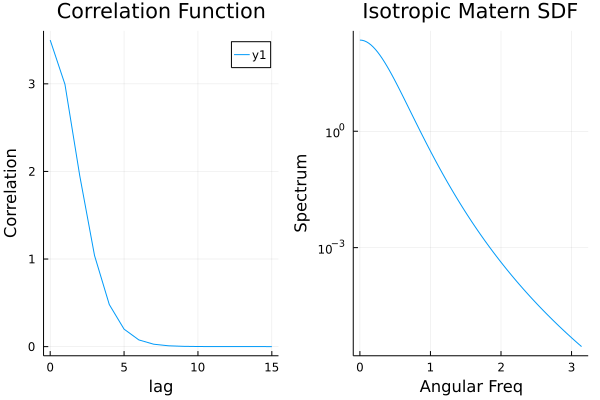

In [12]:
maternsdf(omega) = phi*(rho^(-1.0) + abs2(omega))^(-kappa - Float64(d)/2)

materncor(x) = phi*KernelMatrices.mtn_cor(kappa, x/rho)

pCor = plot(materncor, 0:15, title = "Correlation Function", xlabel = "lag", ylabel = "Correlation")

# This spectral density spans about 6 decades
pS = plot(maternsdf, LinRange(0, 1, 100)*pi, yscale = :log10, 
    ylabel = "Spectrum", xlabel = "Angular Freq", title = "Isotropic Matern SDF", 
    label = "")

plot(pCor, pS)

This plot shows the pair correlations $K(\bf{x}, \bf{x}') = K(\bf{x} - \bf{x}')$ (Stationarity)

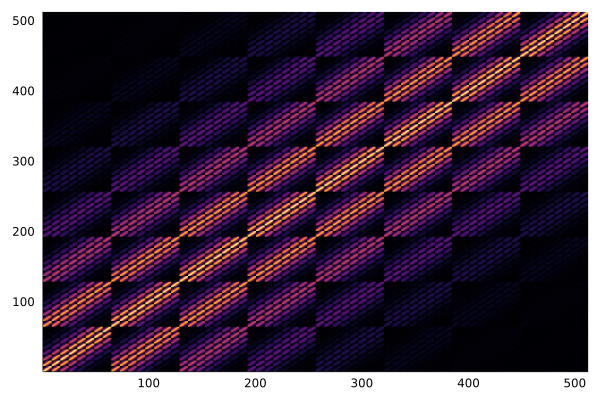

In [76]:
q = heatmap(K[:,:], colorbar = false) 

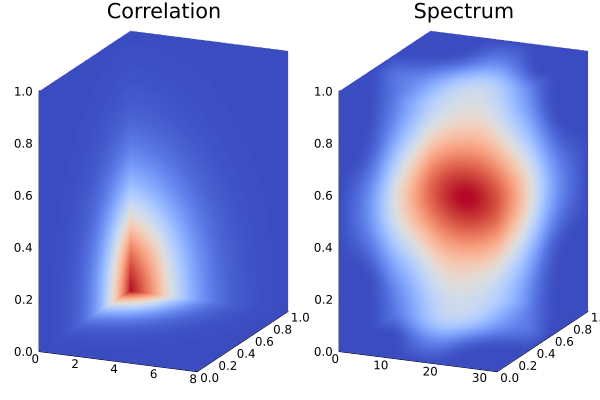

In [5]:
K_stat = reshape(K[:,1], 8,8,8)
Nxz = Nyz = Nzz = 32
Kpad = zeros(Nxz, Nyz, Nzz)
Kpad[1:Nx, 1:Ny, 1:Nz] .= K_stat

S = fftshift(abs2.(fft(Kpad)));
p1 = heatmap(K_stat, title = "Correlation")
p2 = heatmap(log10.(S), title = "Spectrum")

plot(p1, p2)

 Plot a slice of the above

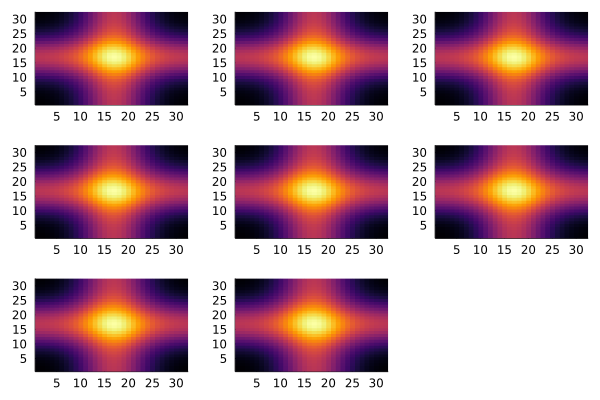

In [6]:
ps = Array{Plots.Plot{Plots.GRBackend},1}(undef, 8)
for i in 1:8
    ps[i] = heatmap(log10.(S[:,:,i + 16]), colorbar = false) #, clims = [cmin, cmax])
end
plot(ps...)

In [9]:
p1d = plot(K_stat[:,1,1], size = (1300, 1300))
plot!(p1d, K_stat[1,:,1])
plot!(p1d, K_stat[1,1,:]);

plot!(LinRange(-pi, pi, 33)[1:end-1], pS,(S[:,1,1]), label = "Estimate")#, yscale = :log10)


LoadError: [91mMethodError: no method matching getindex(::Nothing, ::Int64)[39m

In [63]:
# Step 3: Multiply a Gaussian white noise vector by R
HODLR.symmetricfactorize!(HK_a, plel=pll)
noize = randn(Nx*Ny*Nz);

In [64]:
dat = reshape(HK_a*noize, (Nx, Ny, Nz));
# dat = HK_a*noize

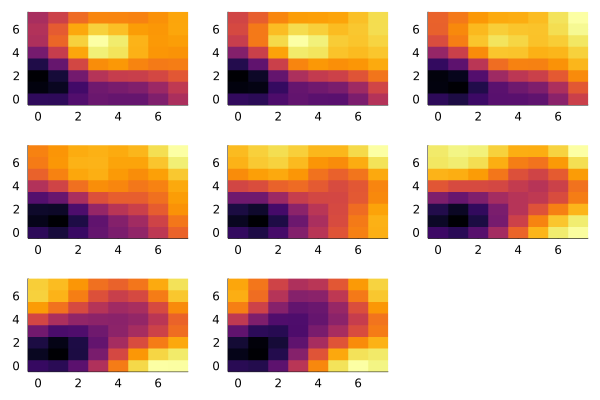

In [65]:
cmin = minimum(dat)
cmax = maximum(dat)
p = Array{Plots.Plot{Plots.GRBackend},1}(undef, 8)
for i in 1:8
    p[i] = heatmap(x, y, dat[:,:,i], colorbar = false) #, clims = [cmin, cmax])
end
plot(p...)

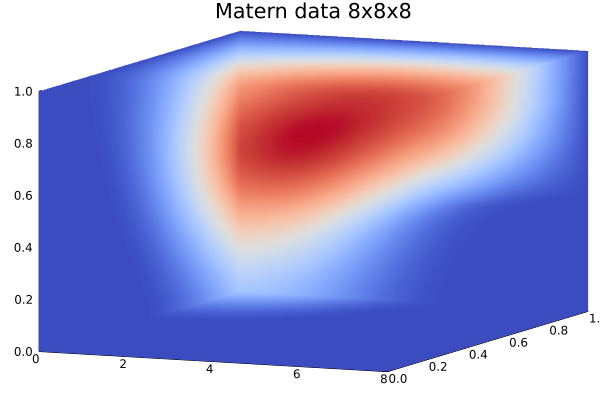

In [32]:
heatmap(dat, title = "Matern data 8x8x8")

In [41]:
# Empirical covariance 
ecov = dat[:]*dat[:]'

heatmap(ecov);

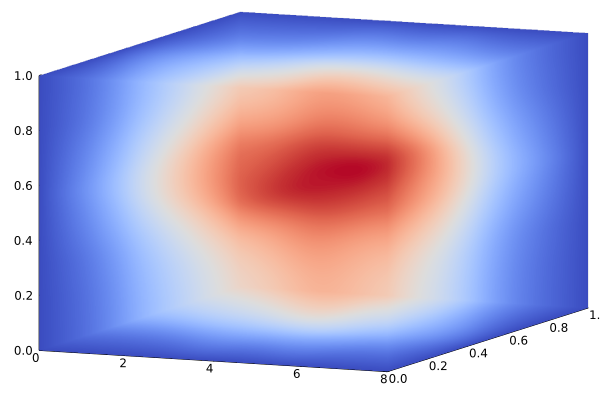

In [37]:
# Compute the periodogram
Pxx = fftshift(abs2.(fft(dat)))

pq = Array{Plots.Plot{Plots.GRBackend},1}(undef, 8)
for i in 1:8
    pq[i] = heatmap(x, y, Pxx[:,:,i], colorbar = false) #, clims = [cmin, cmax])
end
plot(pq..., size = (3000, 1500));

heatmap(log10.(Pxx))

In [38]:
Nxz = Nyz = Nzz = 32
zpad_dat = zeros(Nxz, Nyz, Nzz)
zpad_dat[1:Nx, 1:Ny, 1:Nz] .= dat;

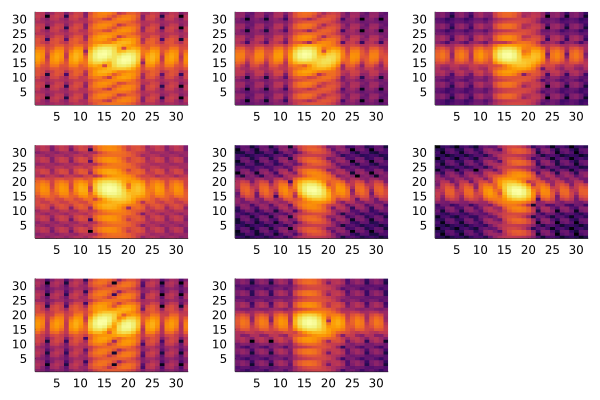

In [40]:
# Compute the periodogram
Pxx = fftshift(abs2.(fft(zpad_dat)))

pq = Array{Plots.Plot{Plots.GRBackend},1}(undef, 8)
for i in 1:8
    pq[i] = heatmap(log10.(Pxx[:,:,i + 16]), colorbar = false) #, clims = [cmin, cmax])
end
plot(pq...)

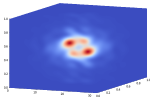

In [80]:
heatmap(Pxx)

In [73]:
sleps = customsleps(2, 4.0, (8,8,8), int = (8,8,8))
sleps[2][1];

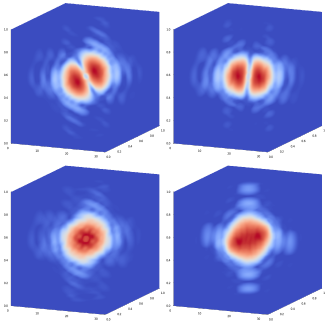

In [87]:
zpad_slep = zeros(Nxz, Nyz, Nzz)

pp = Array{Plots.Plot{Plots.GRBackend},1}(undef, 4)
for i = 1:length(pp)
    zpad_slep[1:Nx, 1:Ny, 1:Nz] .= real.(sleps[2][i])
    pp[i] = heatmap(log10.(fftshift(abs2.(fft(zpad_slep)))))
end
plot(pp..., size = (1300, 1300))


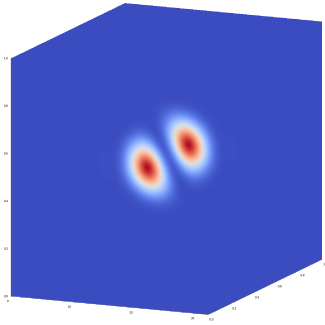

In [78]:
heatmap(Pxx, size = (1300, 1300))